> **Audio-Score Alignment for Traditional Flute Musical Pieces Kernel**

First, some important packages and functions definitions

In [14]:
import sys
sys.path.append('./traditional_dataset/')
sys.path.append('./melosynth/')
import fastdtw 
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import load as ld

def convert2notelist(array,t):
    array_diff = np.abs(np.diff(array))
    array_diff[array_diff>0] = 1 
    onset = []
    note = []
    duration = []
    onset.append(str(t[0]))
    note.append(str(array[0]))
    for i in range(0,len(array_diff)):
        if array_diff[i]==1:
            onset.append(str(t[i+1]))
            note.append(str(array[i+1]))
    for i in range(0, len(onset)):
        if i == (len(onset)-1):
            duration.append(str(float(t[-1:])-float(onset[i])))
        else:
            duration.append(str(float(onset[i+1])-float(onset[i])))
    onset = np.array(onset, dtype='float')
    note = np.array(note, dtype='float')
    duration = np.array(duration, dtype='float')
    
    return onset, note, duration

def note_filter(f0_array, fmin=lr.note_to_midi('B3'), fmax=lr.note_to_midi('B9'), fs=44100, resolution_octave=1, harmonics=0, beta=0.1):
    faux = np.linspace(fmin, fmax, (fmax-fmin)*resolution_octave)
    filter_aux = np.zeros((len(faux), len(f0_array)))
    for j in range(0, len(f0_array)):
        if f0_array[j] == 0:
            filter_aux[:,j] = beta*np.ones(len(faux))
        else:
            idx=resolution_octave*int(f0_array[j]-fmin)
            filter_aux[idx, j] = 1
            if harmonics > 0: 
                if (idx+12*resolution_octave) < len(faux): #octava
                    filter_aux[idx+12*resolution_octave, j] = 1
                if harmonics > 1:    
                    if (idx+19*resolution_octave) < len(faux): #octava + quinta
                        filter_aux[idx+19*resolution_octave, j] = 1
                        if harmonics > 2:    
                            if (idx+24*resolution_octave) < len(faux): #octava + quinta
                                filter_aux[idx+24*resolution_octave, j] = 1            
                            if harmonics > 3:    
                                if (idx+28*resolution_octave) < len(faux): #octava + quinta
                                    filter_aux[idx+28*resolution_octave, j] = 1
                                if harmonics > 4:    
                                    if (idx+31*resolution_octave) < len(faux): #octava + quinta
                                        filter_aux[idx+31*resolution_octave, j] = 1 
                                    if harmonics > 5:    
                                        if (idx+34*resolution_octave) < len(faux): #octava + quinta
                                            filter_aux[idx+31*resolution_octave, j] = 1   

    return filter_aux

Next, main body of code first part: 

Params, audio, score and ground truth loading...

In [15]:
if __name__=="__main__":
   
    #distance function param
    distancefun_param = ['cosine', 'euclidean']
    distancefun = distancefun_param[0]
    print('distance: ' + distancefun)
    
    #bins params
    bins_param = [12, 24, 36]
    bins = bins_param[1]
    print('bins per octave: ' + str(bins))
    
    #range param: flute register
    end_note = lr.note_to_midi('B9')
    range_bins = lr.note_to_midi('B9') - lr.note_to_midi('B3')
    
    #harmonics param
    harmonics_param = [0, 1, 2, 3, 4, 5, 6]
    harmonics = harmonics_param[1]
    print('harmonics in score codification: ' + str(harmonics))
 
    #windows params
    hop_param = [128, 256, 512, 1024, 2048, 4096]
    hop = hop_param[1]
    print('hop size: ' + str(hop))

    #fragment params
    fragments = ld.list_of_fragments('./traditional_dataset/dataset.csv')
    fragment = fragments[27]
    print('fragment: ' + fragment)    

    #load files: audio, gt, score
    audio_file = './traditional_dataset/audio/' + fragment + '.wav'
    audio, t, fs = ld.audio(audio_file)

    gt_file = './traditional_dataset/ground_truth/' + fragment + '.gt'
    gt_onset, gt_note, gt_duration = ld.ground_truth(gt_file)
    gt_note=lr.hz_to_midi(gt_note)
    gt_note[np.isinf(gt_note)]=0    

    score_file = './traditional_dataset/score/' + fragment[0:fragment.rfind('_')] + '.notes'
    score_onset, score_note, score_duration = ld.score(score_file)

    gt_array, gt_t, gt_index = ld.to_array(gt_onset, gt_note, gt_duration, fs, hop)
    score_array, score_t, score_index = ld.to_array(score_onset, score_note, score_duration, fs, hop)

distance: cosine
bins per octave: 24
harmonics in score codification: 1
hop size: 256
fragment: sequenza_second_fragment_robison


In [16]:
    #generate intermediate representation with score
    note_fb = note_filter(score_array, resolution_octave=(bins/12), harmonics=harmonics)         

    C, dummy1, dummy2 = lr.core.cqt(audio, sr=fs, hop_length=hop, fmin=lr.note_to_hz('B3'),
                    n_bins=range_bins*(bins/12),bins_per_octave=bins,tuning=None, 
                    filter_scale=1,sparsity=0.3, norm=1, scale=True)

    Cxx = np.abs(C) + 0.001      
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(note_fb)
    plt.subplot(1,2,2)
    plt.pcolormesh(np.log10(Cxx))

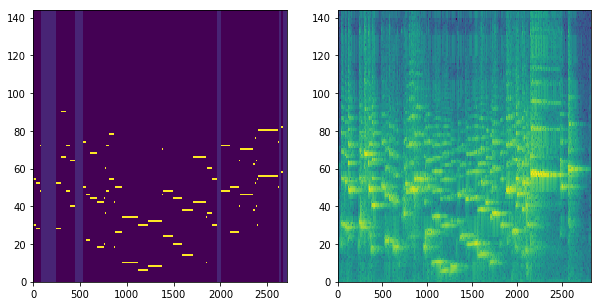

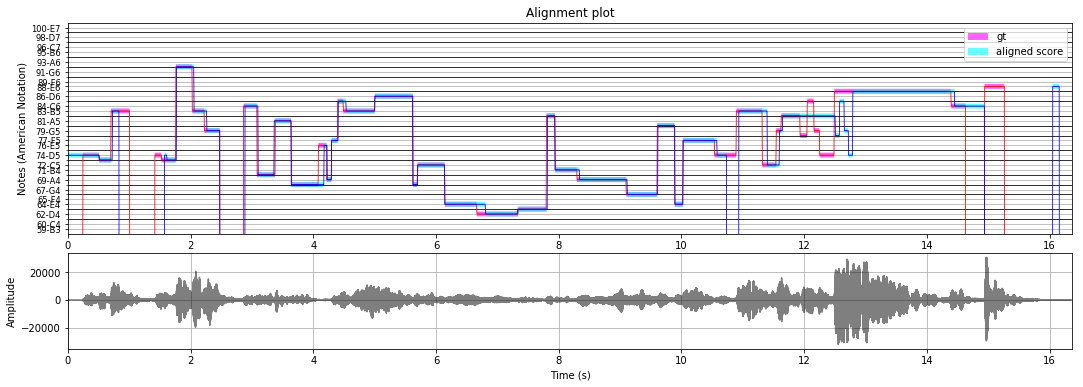

In [17]:
    #%% DTW

    from scipy.spatial.distance import cosine 
    from scipy.spatial.distance import euclidean
    
    if distancefun == 'cosine':
        distance, path, dummy = fastdtw.fastdtw(Cxx.T[:(len(gt_array)-Cxx.shape[1]),:], note_fb.T, dist=cosine)
    elif distancefun == 'euclidean':
        distance, path, dummy = fastdtw.fastdtw(Cxx.T[:(len(gt_array)-Cxx.shape[1]),:], note_fb.T, dist=euclidean)
    path = np.array(path)

#%%  ALIGNMENT PLOTTING

    fig = plt.figure(figsize=(18,6))                                                               
    ax = fig.add_subplot(3,1,(1,2))                                             

    yticks_major = [ 59, 60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 83, 84, 86, 88, 89, 91, 93, 95, 96, 98, 100 ]
    yticks_minor = [ 61, 63, 66, 68, 70, 73, 75, 78, 80, 82, 85, 87, 90, 92, 94, 97, 99 ]
    yticks_labels = ['59-B3', '60-C4', '62-D4', '64-E4', '65-F4', '67-G4', '69-A4', '71-B4', '72-C5', '74-D5', '76-E5', '77-F5', '79-G5', '81-A5', '83-B5', '84-C6', '86-D6', '88-E6', '89-F6', '91-G6', '93-A6', '95-B6', '96-C7', '98-D7', '100-E7']                         

    ax.set_yticks(yticks_major)                                                   
    ax.set_yticks(yticks_minor, minor=True)

    ax.set_yticklabels(yticks_labels, size='small')                                

    ax.set_ylim([58, 101]) #flute register in midi   
    ax.set_xlim([0, gt_t[-1]])
    ax.grid(b=True, which='major', color='black', axis='y', linestyle='-', alpha=0.3)
    ax.grid(b=True, which='minor', color='black', axis='y', linestyle='-', alpha=1)    

    plt.plot(gt_t, gt_array, color='red', lw=0.8)
    plt.plot(gt_t[path[:,0]], score_array[path[:,1]], color='blue', lw=0.8)
    plt.fill_between(gt_t, gt_array-0.5, gt_array+0.5, facecolor='magenta', label='gt', alpha=0.6)
    plt.fill_between(gt_t[path[:,0]], score_array[path[:,1]]-0.5, score_array[path[:,1]]+0.5, facecolor='cyan', label='aligned score', alpha=0.6)
    plt.legend()

    plt.title("Alignment plot")
    plt.ylabel("Notes (American Notation)")

    plt.subplot(3,1,3)
    plt.plot(t, audio, color='black', alpha=0.5)
    plt.grid()
    plt.axis('tight')
    plt.ylabel("Amplitude")
    plt.xlabel("Time (s)")    
    plt.xlim([gt_t[0], gt_t[-1:]])
    plt.show()

In [18]:
align_result = score_array[path[:,1]]        

import melosynth as ms
ms.melosynth_pitch(lr.midi_to_hz(score_array[path[:,1]]), gt_t[path[:,0]], 'melosynth.wav', fs=44100, nHarmonics=3, square=True, useneg=False) 
aligned_audio, t, fs = ld.audio('melosynth.wav')
       
IPython.display.Audio([0.1*aligned_audio,audio[:aligned_audio.shape[0]]], rate=fs)

INFO:Loading data...
INFO:Generating wave...
INFO:Saving wav file...
